In [1]:
import numpy as np
import time
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

## The starting optic

The optic is characterized by a sagitta function with N=100 point to span the space of half of the lens under the assumption that the lens is symmetric. The equation of the optic is derived from the equation for a conic section with the apex at the origin and solving for z:

\begin{equation}
    z(r)=\frac{r^2}{R+\sqrt{R^2-(K+1)r^2}}
\end{equation}

In [2]:
def create_starting_optic(r,R,k=-1,N=100):
    r=np.linspace(0,r,N) #solves the problem of not having enough points close to the origin
    z=r*r/(R+np.sqrt(R*R-(k+1)*r*r))
    optic=np.array([r,z])
    return optic

In [3]:
def find_local_eq(h,optic,N=100):
    # first find nearest point in the lens array to where the ray r intersects
    r=optic[0]
    z=optic[1]
    index=np.abs(r-h).argmin()
    
    # isolate a few points around the closest index (look into how many points we actually want)
    lower=index-3 if index-3>0 else 0 # set the boundary conditions...
    upper=index+3
    
    
    local_r=np.array(r[lower:upper])-h
    local_z=np.array(z[lower:upper])
    
    # Use cubic spline to interpolate the local points
    # need to switch the z and the r coordinates so that cubic spline won't give error
    cs=None
    try:
        cs=CubicSpline(local_r,local_z)
    except:
        print(local_opt)
        print(lower)
        print(upper)
    #zs=np.linspace(local_z[0],local_z[-1],N) 
    return cs

In [4]:
def find_reflect_slope(norm):
    theta=np.arctan(norm)
    slope=np.tan(2*theta)
    return slope

In [5]:
def raytrace(optic, exp_f, Nr=7, linsp=True):
    #create the starting rays
    r=optic[0]
    # make sure that the rays are bounded 
    r_max=r[-1]
    
    rays=np.linspace(0,r_max,Nr) if linsp else np.geomspace(1e-9,r_max,Nr) #confine the rays to the diameter of the optic
    #rays[rays==0]=1e-9 # if r=0 exists set to small value so we don't get infinity values
    raymatrix=[] # 3 points: before, at, after the optic
    after=[]
    for h in rays:
        cs=find_local_eq(h,optic)
        z_optic=cs(0)        
        norm=1/cs(0,1) #The normal is just the derivative 
        slope=find_reflect_slope(norm)
        r_after=slope*(exp_f-z_optic)+h # This is where the ray meets z=exp_f
        ray_z=[z_optic,exp_f]
        ray_r=[h,r_after]            
        raymatrix.append([ray_r,ray_z])
        after.append(r_after)
        #np.concatenate(raymatrix)
    return np.array(raymatrix),np.array(after)

In [6]:
def plot(optic,raymatrix,exp_f,title=None, lambda0=None, norm=False,savefig=False):
    #first plot the optic:
    plt.figure(figsize=(15,10))
    opt_r=optic[0] if not norm else optic[0]/lambda0
    opt_z=optic[1] if not norm else optic[1]/lambda0
    plt.plot(opt_z,opt_r,'b',opt_z,-1*opt_r,'b')
    exp_freq=exp_f if not norm else exp_f/lambda0
    plt.axvline(x=exp_freq, color='k', linestyle='--')
    #Then plot the rays:
    for ray in raymatrix:
        ray_r=ray[0] if not norm else ray[0]/lambda0
        ray_z=ray[1] if not norm else ray[1]/lambda0
        plt.plot(ray_z,ray_r,'r',ray_z,-1*ray_r,'r')
        
    xl='z (m)' if not norm else 'z/lambda'
    yl='r (m)' if not norm else 'r/lambda'
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    plt.xlim((-0.01,exp_f+0.02))
    r_max=max(opt_r)+0.001
    plt.ylim((-r_max,r_max))
    if savefig:
        plt.savefig(title+".png")
    plt.show()
    plt.close()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


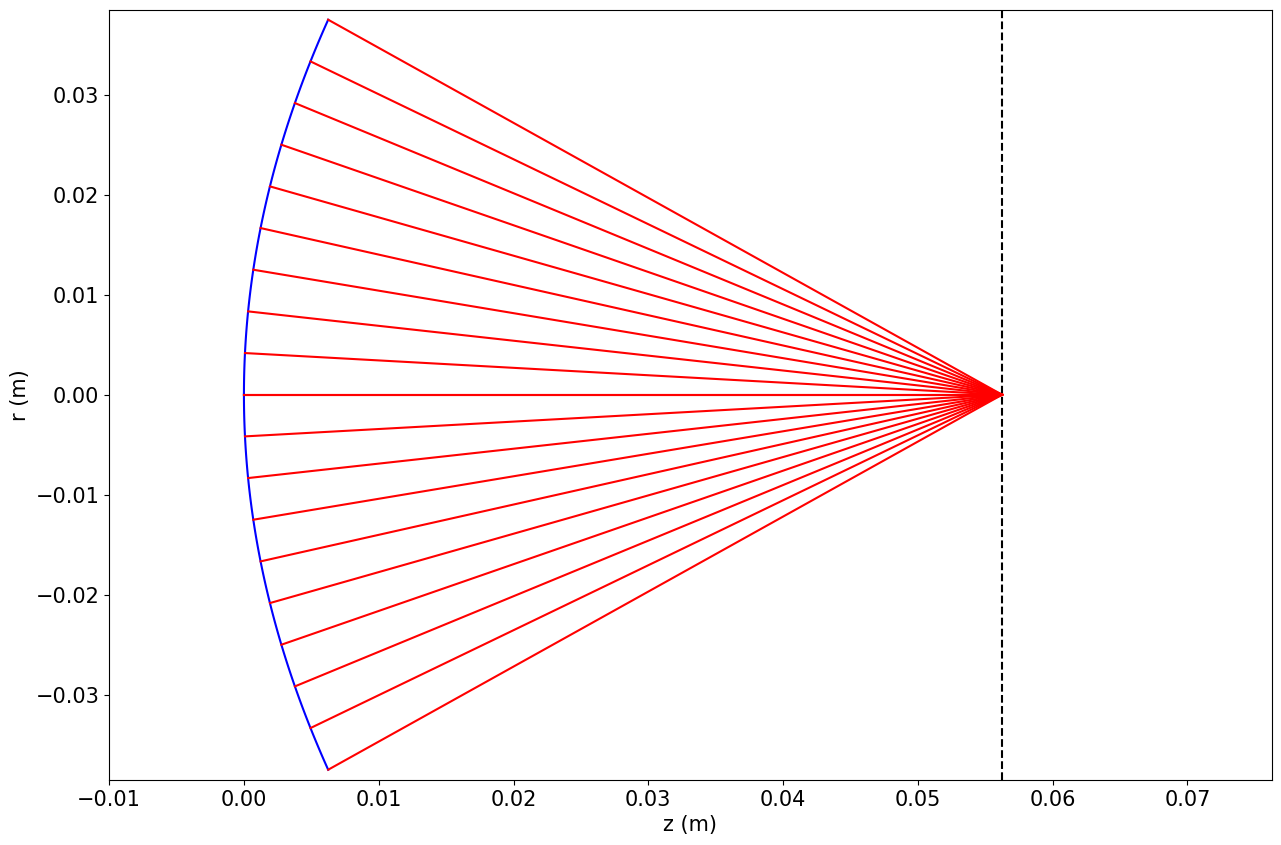

In [7]:
start_o=create_starting_optic(0.0375,0.1125,N=100)
rm,af=raytrace(start_o,0.05625,Nr=10)
plot(start_o,rm,0.05625)

In [7]:
def rms(rays_after):
    n=len(rays_after)
    return np.sqrt(np.sum(rays_after**2)/n)

In [8]:
def grad(i,epsilon,optic,signs,exp_f,Nr):
    o_r=optic[0]
    o_z=optic[1]
    j=i+1
    o_z[j]+=signs[i]*epsilon
    rm1,af1=raytrace([o_r,o_z],exp_f,Nr)
    o_z[j]-=2*signs[i]*epsilon
    rm2,af2=raytrace([o_r,o_z],exp_f,Nr)
    c1=rms(af1)
    c2=rms(af2)
    return c1-c2

In [9]:
def gradient_descent(epsilon,dz,start_k,thick,roc,exp_f,learn_rate,n_iter=1000,tol=1e-6,No=100,Nr=1000,plt=False,title=None):
    start_o=create_starting_optic(thick,roc,k=start_k,N=No)
    o_r=start_o[1]
    os=[start_o[0]]
    rm0,af0=raytrace(start_o,exp_f,Nr)
    cost=[rms(af0)]
    n=0
    if plt:
        plot(start_o,rm0,exp_f,title+"_%d"%(n),savefig=True)
    diff=1e6
    dzs=np.ones(No-1)*dz
    cdz=np.array(dzs)
    #print(dzs)
    print('Step: %d\t Cost: %f'%(n,cost[0]))
    o=start_o[0]
    while(n<n_iter and abs(diff)>tol):
        #print(change_dzs)
        start_time=time.time()
        n+=1
        signs=np.random.choice([-1,1],No-1)
        o[1:]+=signs*dzs #move each point in the optic randomly by dz except for the point at origin
        os.append(o)
        rm,af=raytrace([o,o_r],exp_f,Nr)
        c=rms(af)
        cost.append(c)
        if plt:
            plot([o,o_r],rm,exp_f,title+"_%d"%(n),savefig=True)
        for i in range(len(dzs)):
            step_size=learn_rate*signs[i]*grad(i,epsilon,[o,o_r],signs,exp_f,Nr)
            dzs[i]=dzs[i]-step_size
        diff=c
        cdz=np.vstack([cdz,dzs])
        #print(dzs)
        print('Step: %d\t Cost: %f \t diff: %E \t time: %s'%(n,c,diff,time.time()-start_time))
    return os,o_r,cost,cdz

In [30]:
start_o = create_starting_optic(0.0064,0.1125,k=-0.95,N=100)
sor=np.copy(start_o[1])
rm0,af0=raytrace(start_o,0.05625,100)
cost=rms(af0)

In [31]:
cost

4.96339361057736e-05

In [11]:
soz=np.copy(start_o[0])
signs=np.random.choice([-1,1],99)
dz=signs*5e-7
soz[1:]+=dz 
print(soz)

[0.00000000e+00 6.41464646e-05 1.29792929e-04 1.93439394e-04
 2.58085859e-04 3.23732323e-04 3.88378788e-04 4.53025253e-04
 5.17671717e-04 5.82318182e-04 6.45964646e-04 7.11611111e-04
 7.76257576e-04 8.39904040e-04 9.04550505e-04 9.69196970e-04
 1.03484343e-03 1.09848990e-03 1.16413636e-03 1.22778283e-03
 1.29342929e-03 1.35707576e-03 1.42272222e-03 1.48636869e-03
 1.55101515e-03 1.61566162e-03 1.68030808e-03 1.74595455e-03
 1.81060101e-03 1.87524747e-03 1.93889394e-03 2.00454040e-03
 2.06918687e-03 2.13383333e-03 2.19747980e-03 2.26212626e-03
 2.32677273e-03 2.39141919e-03 2.45606566e-03 2.52171212e-03
 2.58635859e-03 2.65000505e-03 2.71565152e-03 2.77929798e-03
 2.84394444e-03 2.90859091e-03 2.97323737e-03 3.03888384e-03
 3.10253030e-03 3.16817677e-03 3.23182323e-03 3.29646970e-03
 3.36211616e-03 3.42676263e-03 3.49140909e-03 3.55505556e-03
 3.61970202e-03 3.68534848e-03 3.74999495e-03 3.81364141e-03
 3.87928788e-03 3.94393434e-03 4.00858081e-03 4.07222727e-03
 4.13787374e-03 4.202520

In [12]:
g0=[]
g1=[]
for i in range(len(dz)):
    g0.append(grad(i,1e-7,start_o,signs,0.05625,100))
    g1.append(grad(i,1e-7,[soz,sor],signs,0.05625,100))

In [13]:
r=np.linspace(0,0.0375,100)
R=0.1125
z08=r**2/(R+np.sqrt(R**2-(1-0.8)*r**2))
z1=r**2/(R+np.sqrt(R**2-(1-1)*r**2))

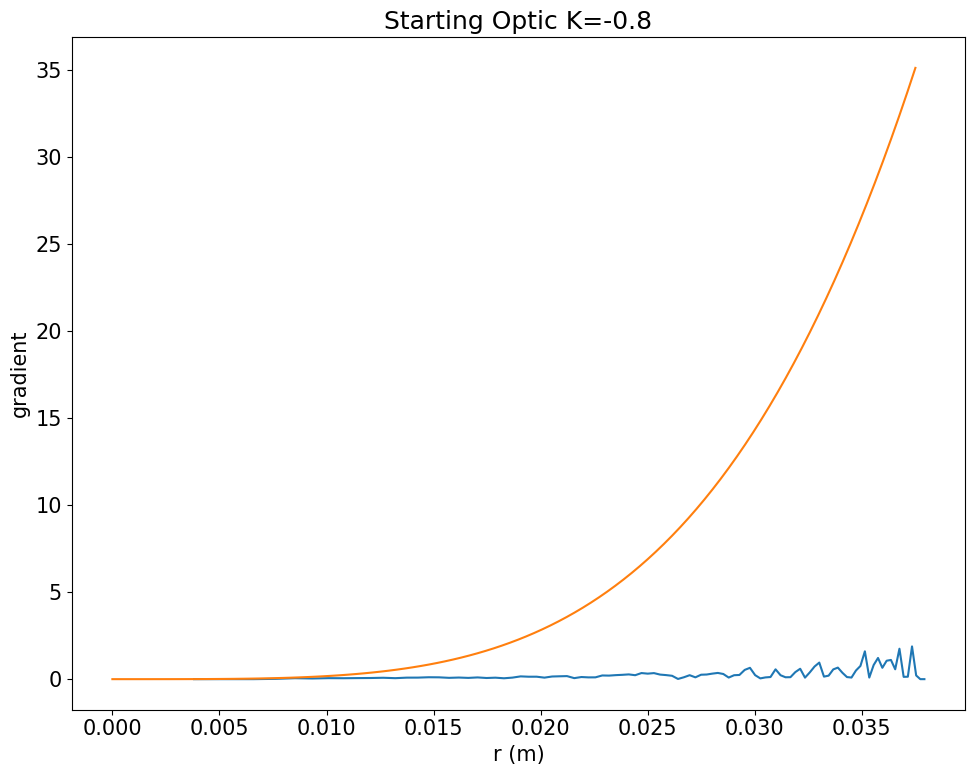

In [32]:
plt.figure(figsize=(10,8))
plt.plot(sor[1:],np.abs(g0)/1e-6)
plt.plot(r,(z08-z1)/1e-6)
plt.xlabel('r (m)')
plt.ylabel('gradient')
plt.title("Starting Optic K=-0.8")
plt.tight_layout()
#plt.savefig('so_norm')
plt.show()

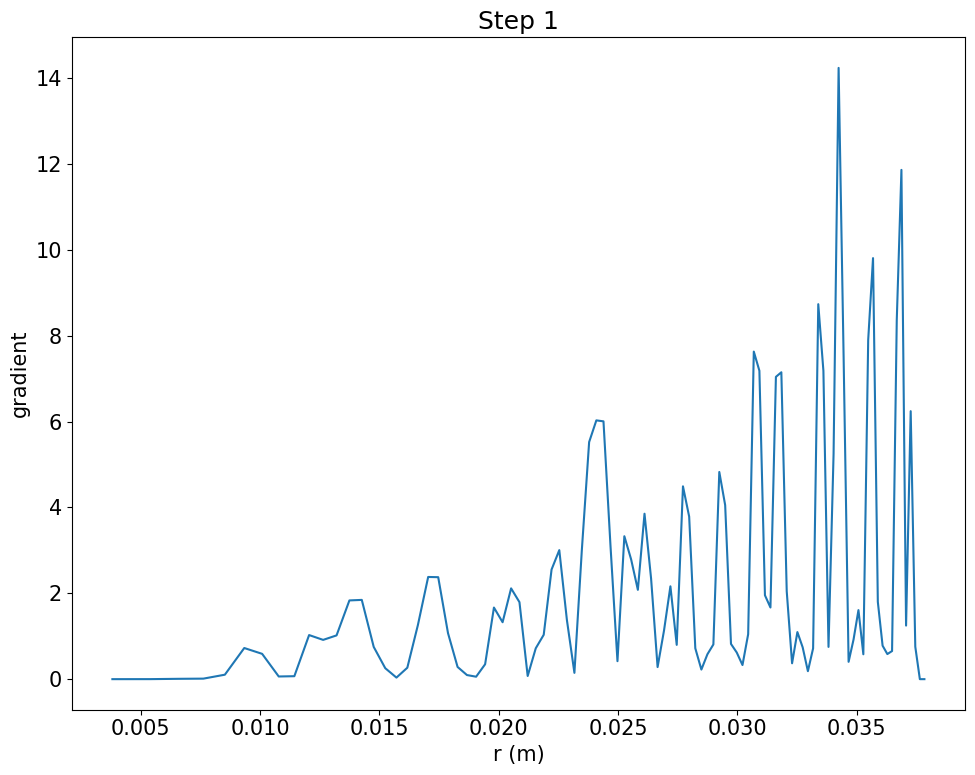

In [16]:
plt.figure(figsize=(10,8))
plt.plot(sor[1:],np.abs(g1)/5e-7)
plt.xlabel('r (m)')
plt.ylabel('gradient')
plt.tight_layout()
plt.title("Step 1")
plt.tight_layout()
plt.savefig('s1')

plt.show()